Imports & device


In [19]:
# Cell 1: imports and device
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms

import torchxrayvision as xrv
import skimage.io

# Device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Helper display function


In [20]:
# Cell 2: small helper functions to show images and overlays
def imshow_rgb(img_rgb, ax=None, title=None):
    if ax is None:
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb)
        if title: plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img_rgb)
        if title: ax.set_title(title)
        ax.axis('off')

def show_two(img1, img2, t1="A", t2="B", figsize=(12,6)):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    imshow_rgb(img1, axs[0], t1)
    imshow_rgb(img2, axs[1], t2)
    plt.show()


locate demo/sample images

In [21]:
# Cell 3: point to example images
# If you committed a small samples/ folder, use it here. Otherwise update path to any local CXR.

# Example: repo-relative demo file (adjust to your repo)
sample_dir = "./samples"   # put 1-3 small demo CXRs here
# print(os.getcwd())
os.makedirs(sample_dir, exist_ok=True)

# If you already have a sample image, set it directly:
# sample_path = "samples/demo1.png"
# Otherwise pick one from data if available:
sample_path = None
# e.g., try common test path
possible = [
    "./samples/IM-0003-0001.jpeg",
    "./samples/person1_virus_6.jpeg"
]
for p in possible:
    if os.path.exists(p):
        sample_path = p
        break

if sample_path is None:
    # If no local dataset, ask user to put one image into samples/ and set `sample_path`.
    print("No sample found automatically. Put one demo CXR in `samples/` and set sample_path = 'samples/yourfile.png'")
else:
    print("Using sample:", sample_path)


Using sample: ./samples/IM-0003-0001.jpeg


load & inspect raw image statistics

rest ./samples/IM-0003-0001.jpeg
Original shape (H,W,C): (1509, 2111, 3)  dtype: uint8
Pixel range: min = 0 max = 255


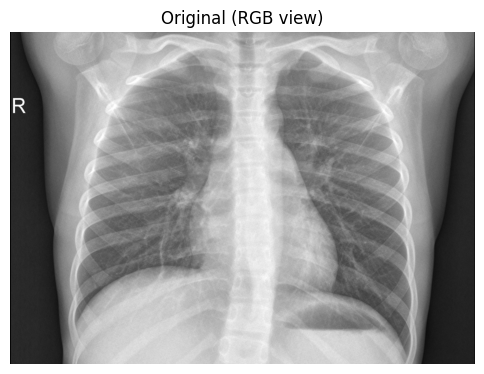

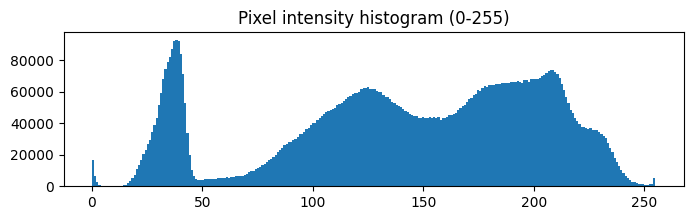

In [22]:
# Cell 4: load sample, check shape, dtype, min/max, and show image
print("rest",sample_path)
img_bgr = cv2.imread(sample_path)            # BGR (OpenCV)
if img_bgr is None:
    raise FileNotFoundError(f"sample_path not found: {sample_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print("Original shape (H,W,C):", img_rgb.shape, " dtype:", img_rgb.dtype)
print("Pixel range: min =", img_rgb.min(), "max =", img_rgb.max())

# show
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title("Original (RGB view)")
plt.axis('off')
plt.show()

# show histogram (helps see contrast)
plt.figure(figsize=(8,2))
plt.hist(img_rgb.ravel(), bins=256)
plt.title("Pixel intensity histogram (0-255)")
plt.show()


XRV normalization & single-channel conversion (important)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1024.0..1024.0].


skimage read shape: (1509, 2111)  dtype: uint8
After xrv.normalize: min, max: -1024.0 1024.0


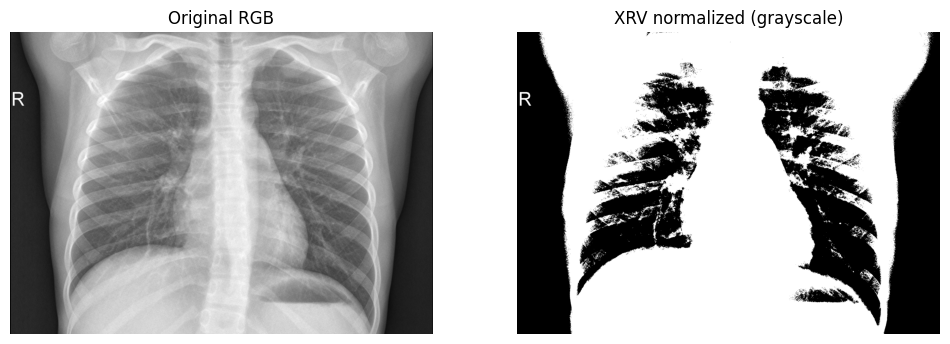

In [23]:
# Cell 5: show XRV preprocessing effect (normalize + single-channel)
# TorchXRayVision expects images scaled in a certain way; we use xrv.datasets.normalize

img_raw = skimage.io.imread(sample_path)  # may return grayscale or RGB
print("skimage read shape:", img_raw.shape, " dtype:", img_raw.dtype)

# XRV normalize: expects 8-bit input scaled -> returns float with CXR scale
img_norm = xrv.datasets.normalize(img_raw, 255)  # map 0..255 -> XRV range convention
print("After xrv.normalize: min, max:", img_norm.min(), img_norm.max())

# Convert to single channel (mean) as X-rays are single-channel
if img_norm.ndim == 3:
    img_gray = img_norm.mean(axis=2)
else:
    img_gray = img_norm

# Visualize side by side: original (RGB) vs normalized grayscale
show_two(img_rgb, np.stack([img_gray]*3, axis=-1), t1="Original RGB", t2="XRV normalized (grayscale)")


load PSPNet segmentation model & list anatomical labels

In [24]:
# Cell 6: load PSPNet segmentation model and inspect targets
print("Loading PSPNet segmentation model (this may download weights first time)...")
seg_model = xrv.baseline_models.chestx_det.PSPNet().to(device).eval()

print("Segmentation model targets (anatomical labels):")
print(seg_model.targets)   # list of labels, e.g. ["Left Lung", "Right Lung", ...]

Loading PSPNet segmentation model (this may download weights first time)...
Segmentation model targets (anatomical labels):
['Left Clavicle', 'Right Clavicle', 'Left Scapula', 'Right Scapula', 'Left Lung', 'Right Lung', 'Left Hilus Pulmonis', 'Right Hilus Pulmonis', 'Heart', 'Aorta', 'Facies Diaphragmatica', 'Mediastinum', 'Weasand', 'Spine']


prepare image for PSPNet and run segmentation (512x512)

In [25]:
# Cell 7: helper to prepare and run segmentation
from torchvision import transforms

def prep_for_seg_xrv(image_path, out_size=512):
    arr = skimage.io.imread(image_path)
    arr = xrv.datasets.normalize(arr, 255)   # XRV convention
    if arr.ndim == 3:
        arr = arr.mean(2)
    arr = arr[None, ...]  # [1, H, W]
    transform = transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(out_size)
    ])
    arr = transform(arr)      # still numpy [1, out_size, out_size]
    tensor = torch.from_numpy(arr).unsqueeze(0).to(device).float()  # [1,1,out_size,out_size]
    return tensor

img_t = prep_for_seg_xrv(sample_path, out_size=512)
with torch.no_grad():
    seg_logits = seg_model(img_t)              # [1, num_targets, 512, 512]
    seg_prob = torch.sigmoid(seg_logits)[0]    # [num_targets, 512, 512]
print("seg_prob shape:", seg_prob.shape)


seg_prob shape: torch.Size([14, 512, 512])


visualize left/right lung probability maps and binary mask

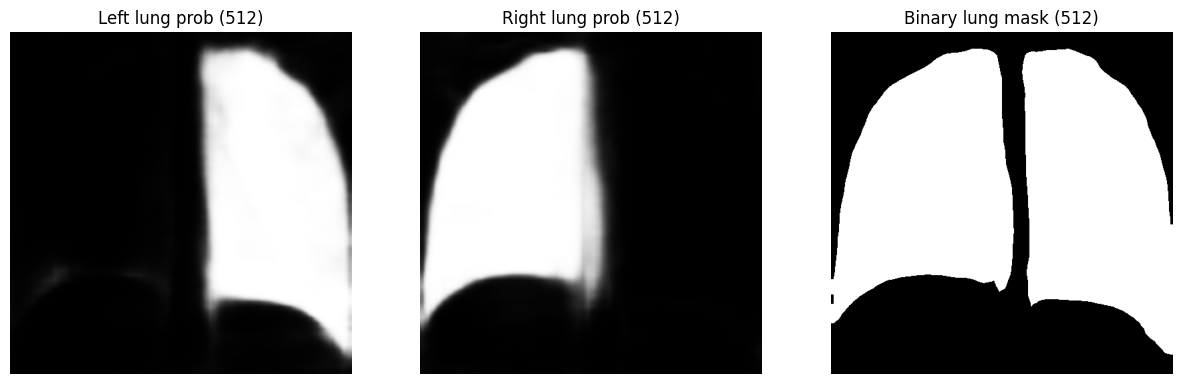

In [26]:
# Cell 8: find indices for Left/Right Lung and combine
targets = seg_model.targets
left_idx = targets.index("Left Lung")
right_idx = targets.index("Right Lung")
left = seg_prob[left_idx].cpu().numpy()
right = seg_prob[right_idx].cpu().numpy()

# combined probability (max of both)
lung_prob_512 = np.maximum(left, right)   # values 0..1 at 512x512
lung_mask_512 = (lung_prob_512 > 0.5).astype(np.uint8)

# show probabilities and mask
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(left, cmap='gray'); axs[0].set_title("Left lung prob (512)")
axs[1].imshow(right, cmap='gray'); axs[1].set_title("Right lung prob (512)")
axs[2].imshow(lung_mask_512, cmap='gray'); axs[2].set_title("Binary lung mask (512)")
for a in axs: a.axis('off')
plt.show()


resize mask back to original image size and overlay

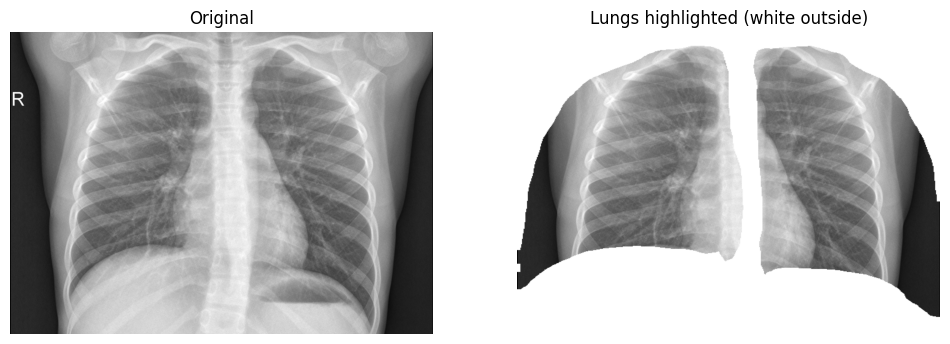

In [27]:
# Cell 9: resize mask to original image dims and overlay onto original image
orig_bgr = cv2.imread(sample_path)
H, W = orig_bgr.shape[:2]
lung_mask_orig = cv2.resize((lung_mask_512*255).astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
lung_mask_bin = (lung_mask_orig > 127).astype(np.uint8)

# overlay (white outside lungs)
overlay = orig_bgr.copy()
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
overlay_rgb[lung_mask_bin == 0] = 255  # white background outside lungs

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original")
axs[1].imshow(overlay_rgb); axs[1].set_title("Lungs highlighted (white outside)")
for a in axs: a.axis('off')
plt.show()


quick checklist & notes (what to look for)


# Checklist (manually inspect)
- [ ] Does the lung mask cover both lungs and not huge unrelated regions?
- [ ] Is the mask reasonably tight (not too many holes)?
- [ ] Is the mask aligned (no big shift vs original image)?
- [ ] Are image intensities reasonable (not fully black/white)?

If something looks wrong:
- Try a different sample image to check consistency.
- Check if the original image needs cropping/rotation.
- If segmentation is noisy, we can add simple morphological post-processing (close/fill).


In [28]:
# Optional: inspect classifier pathologies available in XRV
# A common XRV classifier has attribute `pathologies`
# Try to load a light classifier (this will download weights if needed)

clf = xrv.models.get_model("densenet121-res224-all")  # if available in your xrv version
print("Classifier pathologies (densenet):")
print(clf.pathologies)


If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O C:\Users\abdel\.torchxrayvision\models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
Classifier pathologies (densenet):
['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
